# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

100%|██████████| 480/480 [00:07<00:00, 62.92it/s]


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [8]:
import os

allFiles = []
for root, dirs, files in os.walk('./12words'):
    allFiles += [os.path.join(root, f) for f in files
                    if f.endswith('.npy')]
allFiles[0]

'./12words/9/31-(9).mp3.npy'

In [9]:
labels = [int(file_name.split("(")[1].split(")")[0]) for file_name in allFiles]
transform = {j:i for i, j in enumerate(set(labels))}
labels = [transform[i] for i in labels]

In [10]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(allFiles, labels, test_size=0.2, random_state=10)

trainY = {id:y for id, y in zip(trainX, trainY)}
testY = {id:y for id, y in zip(testX, testY)}

In [11]:
sr = 16000 #we know this one for google audios
iLen = 48000
trainGen = SpeechGenerator.SpeechGen(trainX, trainY, shuffle=True, dim=iLen)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
# valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(testX, testY, shuffle=False, batch_size=len(testX), dim=iLen)
testRGen  = SpeechGenerator.SpeechGen(testX, testY, shuffle=False, batch_size=len(testX), dim=50_000)
# valGen  = SpeechGenerator.SpeechGen(testX, testY, shuffle=False, batch_size=len(testX), dim=50_000)
# testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
testGen.__len__()

1

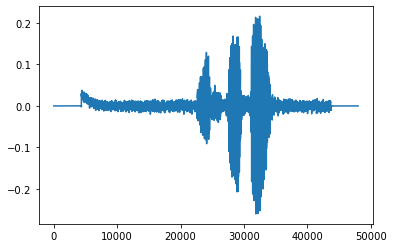

In [13]:
# import librosa
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
# print(audios[0].shape)
plt.plot(audios[3])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model

inp = L.Input((iLen,), name='input')
mel_spec = audioUtils.normalized_mel_spectrogram(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Model: "normalized_spectrogram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 48000)]      0           []                               
                                                                                                  
 tf.signal.stft (TFOpLambda)    (None, 375, 513)     0           ['input[0][0]']                  
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 375, 513)     0           ['tf.signal.stft[0][0]']         
                                                                                                  
 tf.tensordot (TFOpLambda)      (None, 375, 80)      0           ['tf.math.abs[0][0]']            
                                                                       

In [15]:
audios.shape

(32, 48000)

In [16]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 [==============================] - 1s 759ms/step


(-1.730841, 1.4936792, -0.34930715)

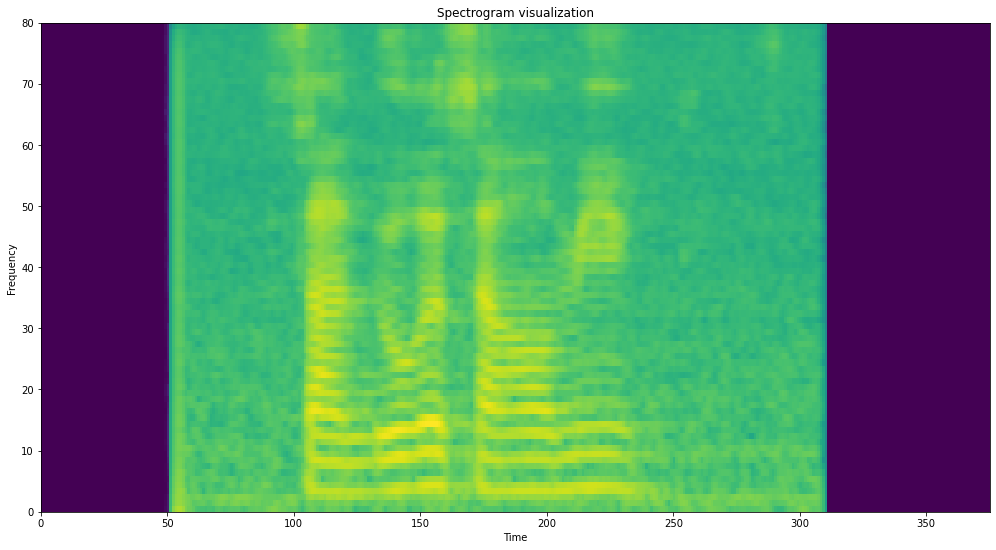

In [17]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[1,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [18]:
import librosa

# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(-80.0, 0.0)

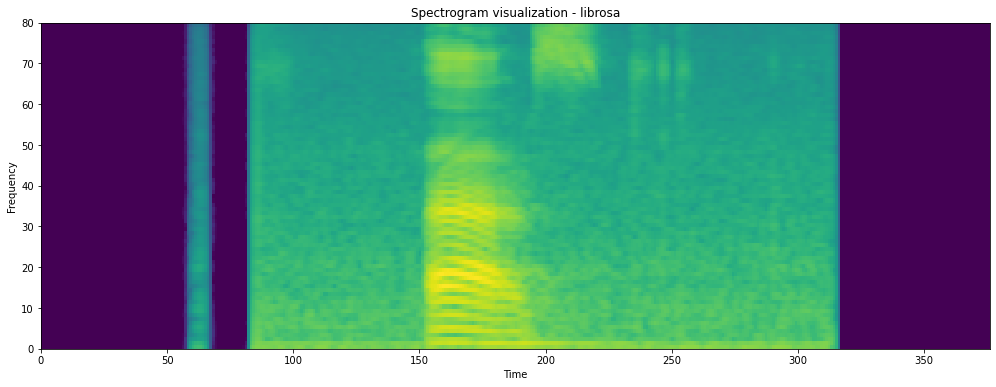

In [19]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [20]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [21]:
from tensorflow.keras.models import Model, load_model

In [22]:
# model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
model = SpeechModels.AttRNNSpeechModel(36, samplingrate = sr, inputLength = None)
model.load_weights('model-attRNN.h5')

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 normalized_spectrogram_model (  (None, None, 80)    0           ['input[0][0]']                  
 Functional)                                                                                      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 80, 1)  0           ['normalized_spectrogram_model[0]
                                                                 [0]']                            
                                                                                              

In [23]:
# model.load_weights('model-attRNN.h5')

In [24]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [25]:
earlystopper = EarlyStopping(monitor='val_loss', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN-reza.h5', monitor='val_loss', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=testGen, epochs=60, use_multiprocessing=False, workers=4, verbose=1,
                    callbacks=[earlystopper, checkpointer])#, lrate])

model.save('model-attRNN-reza-end.h5')

Epoch 1/60
12/12 [==============================] - ETA: 0s - loss: 10.0187 - sparse_categorical_accuracy: 0.0521
Epoch 1: val_loss improved from inf to 5.28615, saving model to model-attRNN-reza.h5
12/12 [==============================] - 21s 1s/step - loss: 10.0187 - sparse_categorical_accuracy: 0.0521 - val_loss: 5.2862 - val_sparse_categorical_accuracy: 0.0729
Epoch 2/60
12/12 [==============================] - ETA: 0s - loss: 3.5396 - sparse_categorical_accuracy: 0.1536
Epoch 2: val_loss improved from 5.28615 to 3.41528, saving model to model-attRNN-reza.h5
12/12 [==============================] - 13s 1s/step - loss: 3.5396 - sparse_categorical_accuracy: 0.1536 - val_loss: 3.4153 - val_sparse_categorical_accuracy: 0.1042
Epoch 3/60
12/12 [==============================] - ETA: 0s - loss: 2.0236 - sparse_categorical_accuracy: 0.3880
Epoch 3: val_loss improved from 3.41528 to 3.09479, saving model to model-attRNN-reza.h5
12/12 [==============================] - 13s 1s/step - loss: 2

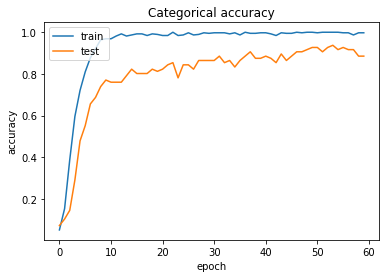

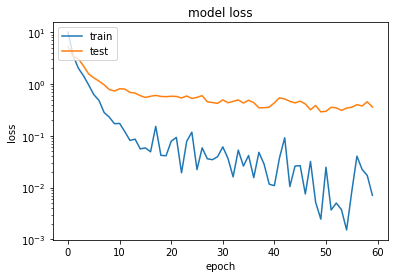

In [31]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation and Attention Plots

In [74]:
model.load_weights('model-attRNN-reza.h5')

#read all test data
x_test, y_test = testGen.__getitem__(0)

valEval = model.evaluate(testGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.03334837779402733, 0.9921875] 
Validation: [0.30397745966911316, 0.9166666865348816] 
Test: [0.3229670226573944, 0.9270833134651184]


In [75]:
y_pred = model.predict(x_test, verbose=1)

3/3 [==============================] - 2s 545ms/step


In [76]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [77]:
classes = ["oragh", "arz", "sekeh", "bank", "tala", "naft", "moshtaghat", "felezat", "sahami", "sabet", "mokhtalet", "ghabel-moamele"]

Confusion matrix, without normalization


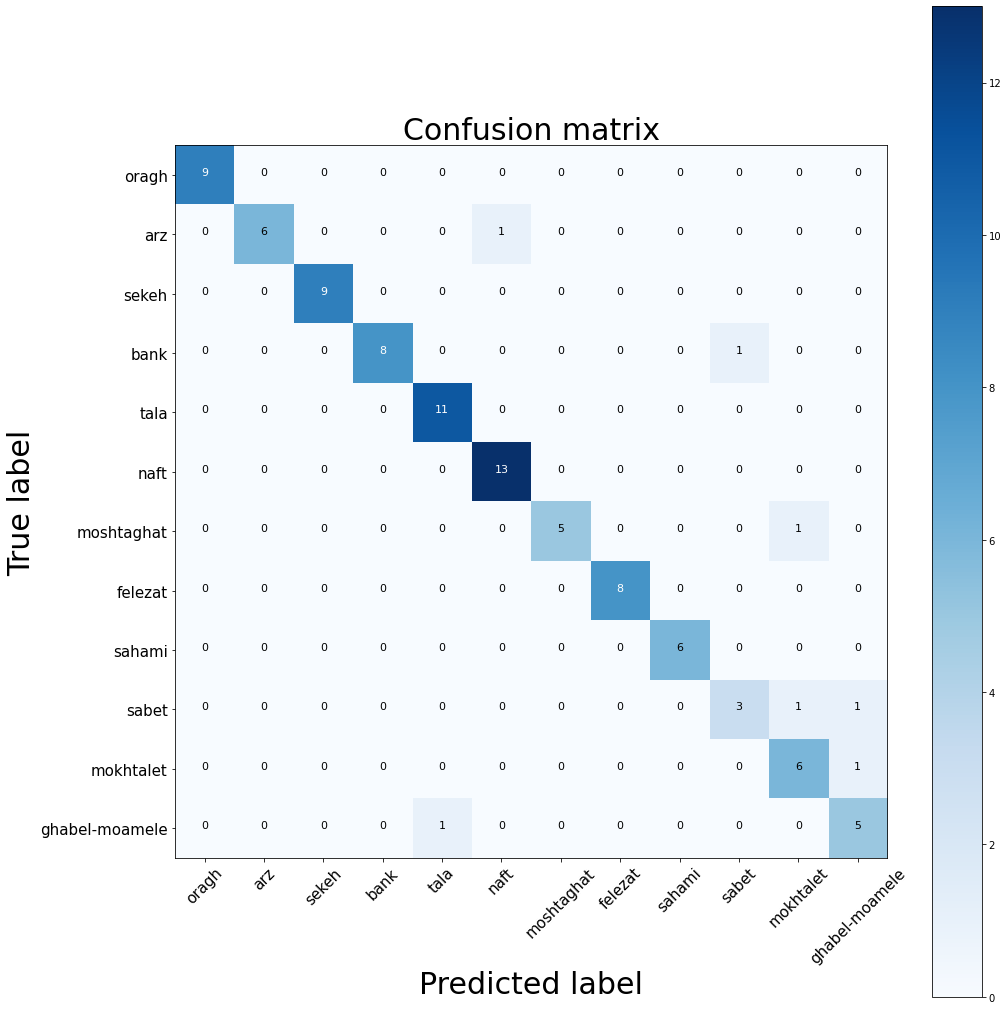

In [78]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)